In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr 
import math

In [4]:
df_total = pd.read_csv('test_player_dataframe.tsv',sep='\t')

df_total.Salary = df_total['Salary'].str.replace('$','')
df_total.Salary = df_total['Salary'].str.replace(',','')
#print(df_total.Salary)

df_total.Salary = df_total['Salary'].astype(float)
print(type(df_total.Salary[5]))
print(df_total.columns.values)
df_total.head()

<class 'numpy.float64'>
['Unnamed: 0' 'Season' 'Age' 'Tm' 'Lg' 'Pos' 'G' 'GS' 'MP_x' 'FG' 'FGA'
 'FG%' '3P' '3PA' '3P%' '2P' '2PA' '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB'
 'DRB' 'TRB' 'AST' 'STL' 'BLK' 'TOV' 'PF' 'PTS' 'MP_y' 'PER' 'TS%' '3PAr'
 'FTr' 'ORB%' 'DRB%' 'TRB%' 'AST%' 'STL%' 'BLK%' 'TOV%' 'USG%' 'OWS' 'DWS'
 'WS' 'WS/48' 'OBPM' 'DBPM' 'BPM' 'VORP' 'Team' 'Salary' 'Player']


,Unnamed: 0,Season,Age,Tm,Lg,Pos,G,GS,MP_x,FG,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Team,Salary,Player
0,0,2000-01,23.0,NJN,NBA,PF,68.0,68.0,33.4,5.1,...,2.5,2.1,0.044,-2.6,1.9,-0.7,0.8,New Jersey Nets,3536640.0,Kenyon Martin
1,1,2001-02,24.0,NJN,NBA,PF,73.0,73.0,34.3,6.1,...,4.2,4.9,0.093,-1.3,2.2,0.9,1.8,New Jersey Nets,3801960.0,Kenyon Martin
2,2,2002-03,25.0,NJN,NBA,PF,77.0,77.0,34.1,6.6,...,5.3,7.1,0.129,-0.8,2.0,1.2,2.1,New Jersey Nets,4067160.0,Kenyon Martin
3,3,2003-04,26.0,NJN,NBA,PF,65.0,62.0,34.6,6.8,...,5.1,6.7,0.142,-1.0,2.9,1.9,2.2,New Jersey Nets,5128689.0,Kenyon Martin
4,4,2004-05,27.0,DEN,NBA,PF,70.0,67.0,32.5,6.3,...,3.6,5.3,0.111,-0.5,2.1,1.6,2.1,Denver Nuggets,9454546.0,Kenyon Martin


In [58]:
df_advanced = df_total[['WS','DWS','USG%','PER','TS%','DBPM','OBPM','BPM','VORP','Salary','Player']]
df_traditional = df_total[['Age','GS','MP_x','FGA','PTS','TRB','AST','TOV','STL','BLK','Salary']]

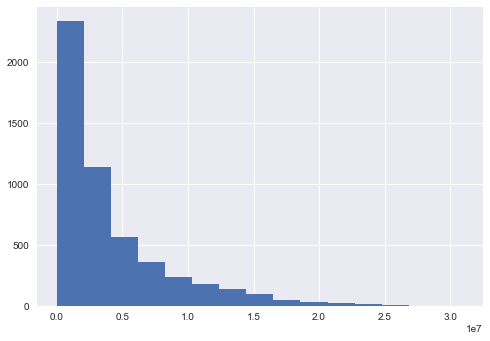

In [54]:
plt.hist(df_total['Salary'],bins=15)
plt.show()

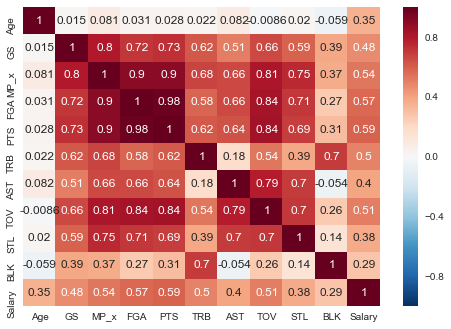

In [57]:
corr = df_traditional.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
plt.show()

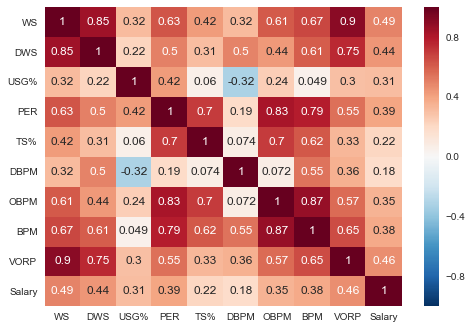

In [59]:
corr = df_advanced.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
plt.show()

In [50]:
players = df_total['Player'].unique()

list_of_rookie_contract_data = []
list_of_first_contract_data = []
list_of_columns_to_average = ['Age','G','GS','MP_x','FG','FGA',
 'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB',
 'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','MP_y','PER','TS%','3PAr',
 'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
 'WS','WS/48','OBPM','DBPM','BPM','VORP']
list_of_averaged_rows = []

#For each player in original dataset, create a Rookie table of just his first 4 seasons
#Also create a Contract datatable of his first year with the new contract
for player in players:
    df_player = df_total[df_total['Player'] == player]
    df_player_rookie = df_player.iloc[0:3]
    df_player_contract = df_player.iloc[4:5]
#Append these individual dataframes to separate lists, they will later be concatendated into one larger dataframe    
    list_of_rookie_contract_data.append(df_player_rookie)
    list_of_first_contract_data.append(df_player_contract)

#############################################################################################
# Create a dataframe of the weight averages of numerical columns during players first 4 seasons
#############################################################################################    
    weight_array =[]
    total_minutes = 0
    for index, row in df_player_rookie.iterrows():
        #The weight used will be based off minutes played for each seasons
        weight = row.MP_x * row.G
        #Make an array of the weights for each season
        weight_array.append(weight)
        total_minutes = weight + total_minutes
    #If they didn't play in a given season, skip    
    if total_minutes == 0:
        continue
    #Normalize the weight array    
    weight_array[:] = [x / total_minutes for x in weight_array]

    ##Iterate through the new Rookie dataframe, apply weighted average for numerical columns
    ##If column is Salary, grab it from the Contract table
    ##If column is non-numeric, just add a placeholder value to the row
    new_row = []
    if len(df_player) <5:
        continue
    for column in df_player_rookie.columns:        
        if column in list_of_columns_to_average:
            new_row.append(np.dot(weight_array,df_player_rookie[column]))
        elif column == 'Salary':
            new_row.append(df_player.iloc[4:5]['Salary'].values[0])
        else:
            var = df_player_rookie.iloc[:-2][column].values[0]
            new_row.append(var)
    list_of_averaged_rows.append(new_row)
list_of_averaged_rows = pd.Series(list_of_averaged_rows)

##Make the larger rookie and contract dataframes
df_rookie_total = pd.concat(list_of_rookie_contract_data)
df_contract_total = pd.concat(list_of_first_contract_data)
##Make the larger rookie_averages dataframe
df_rookie_averages = pd.DataFrame.from_items(zip(list_of_averaged_rows.index,list_of_averaged_rows.values)).T
df_rookie_averages.columns = list(df_total.columns.values)
#print(df_rookie_total)

Points and Salary Correlation
(0.67961147285054435, 5.3848929085003096e-62)


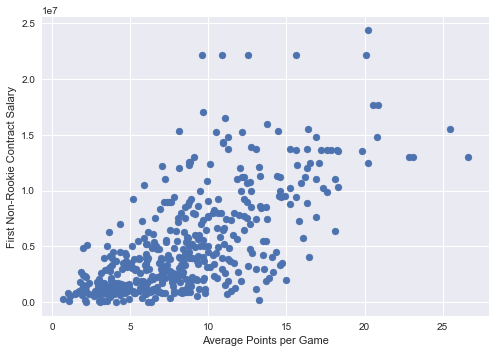

In [54]:
#corr = df_rookie_averages.corr()
#heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=False)

plt.scatter(df_rookie_averages['PTS'],df_rookie_averages['Salary'])
plt.xlabel('Average Points per Game')
plt.ylabel('First Non-Rookie Contract Salary')

print('Points and Salary Correlation')
print(pearsonr(df_rookie_averages['PTS'],df_rookie_averages['Salary']))

plt.show()

Assists and Salary Correlation
(0.3895915563519155, 1.092389965577114e-17)


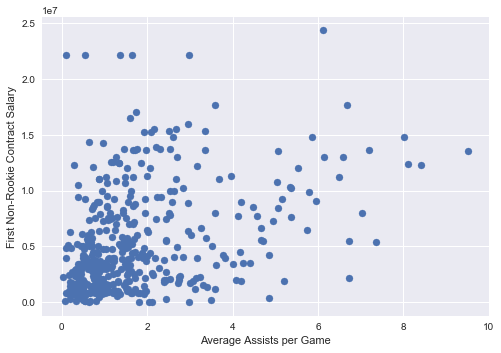

In [48]:
plt.scatter(df_rookie_averages['AST'],df_rookie_averages['Salary'])
plt.xlabel('Average Assists per Game')
plt.ylabel('First Non-Rookie Contract Salary')

print('Assists and Salary Correlation')
print(pearsonr(df_rookie_averages['AST'],df_rookie_averages['Salary']))

plt.show()

Points and Salary Correlation
(0.59183156543965521, 1.1048333173284887e-43)


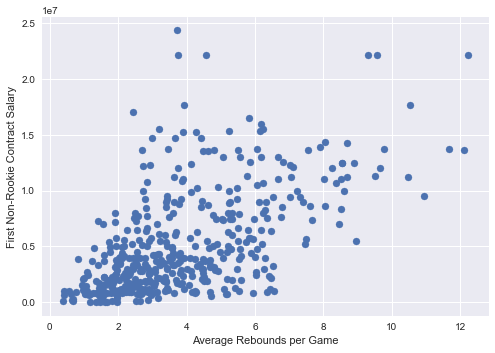

In [49]:
plt.scatter(df_rookie_averages['TRB'],df_rookie_averages['Salary'])
plt.xlabel('Average Rebounds per Game')
plt.ylabel('First Non-Rookie Contract Salary')

print('Points and Salary Correlation')
print(pearsonr(df_rookie_averages['TRB'],df_rookie_averages['Salary']))

plt.show()

Points and Salary Correlation
(0.49221676264400172, 1.0296344774658454e-28)


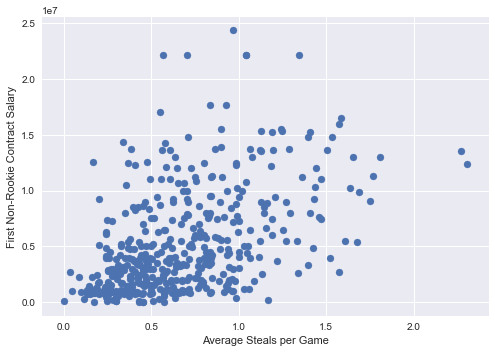

In [55]:
plt.scatter(df_rookie_averages['STL'],df_rookie_averages['Salary'])
plt.xlabel('Average Steals per Game')
plt.ylabel('First Non-Rookie Contract Salary')

print('Points and Salary Correlation')
print(pearsonr(df_rookie_averages['STL'],df_rookie_averages['Salary']))

plt.show()

Assists and Salary Correlation
(0.73337253674326286, 9.1318783229906773e-77)


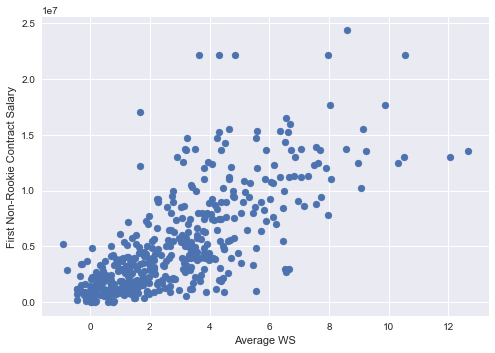

In [56]:
plt.scatter(df_rookie_averages['WS'],df_rookie_averages['Salary'])
plt.xlabel('Average WSplt.scatter(df_rookie_averages['AST'],df_rookie_averages['Salary'])
plt.xlabel('Average Assists per Game')
plt.ylabel('First Non-Rookie Contract Salary')

print('Assists and Salary Correlation')
print(pearsonr(df_rookie_averages['AST'],df_rookie_averages['Salary']))

plt.show()')
plt.ylabel('First Non-Rookie Contract Salary')

print('Assists and Salary Correlation')
print(pearsonr(df_rookie_averages['WS'],df_rookie_averages['Salary']))

plt.show()

Assists and Salary Correlation
(0.67572903638769399, 4.7430164461640887e-61)


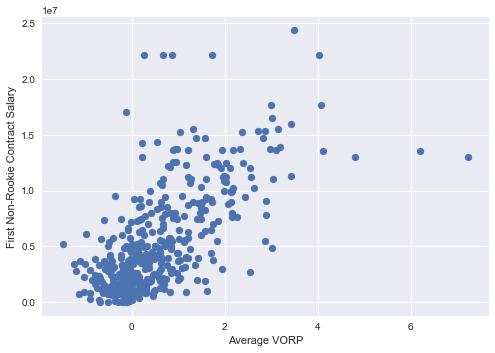

In [58]:
plt.scatter(df_rookie_averages['VORP'],df_rookie_averages['Salary'])
plt.xlabel('Average VORP')
plt.ylabel('First Non-Rookie Contract Salary')

print('Assists and Salary Correlation')
print(pearsonr(df_rookie_averages['VORP'],df_rookie_averages['Salary']))

plt.show()

Shooting Effectiveness and Salary Correlation
(0.64115070234743521, 3.105966641218032e-53)


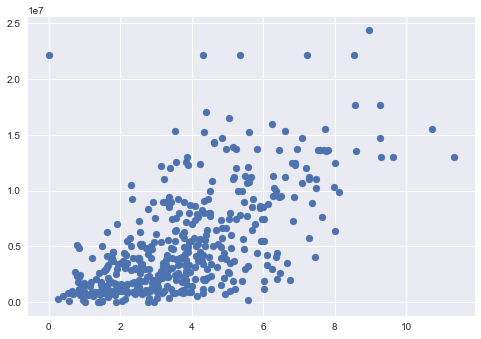

In [97]:
shooting_effectiveness = df_rookie_averages['FGA'] * df_rookie_averages['TS%']

for index,val in shooting_effectiveness.iteritems():
    if math.isnan(val):
        shooting_effectiveness[index]=0
        
plt.scatter(shooting_effectiveness,df_rookie_averages['Salary'])

print('Shooting Effectiveness and Salary Correlation')
print(pearsonr(df_rookie_averages['Salary'],shooting_effectiveness))

plt.show()

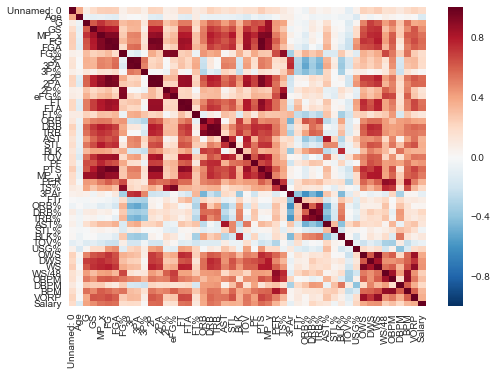

In [40]:
corr = df_rookie_total.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=False)
plt.show()

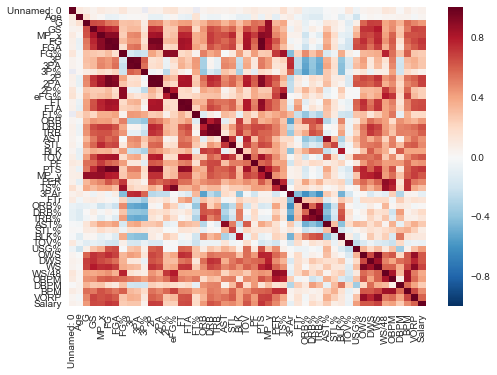

In [91]:
corr = df_contract_total.corr()
heat_map = sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=False)
plt.show()

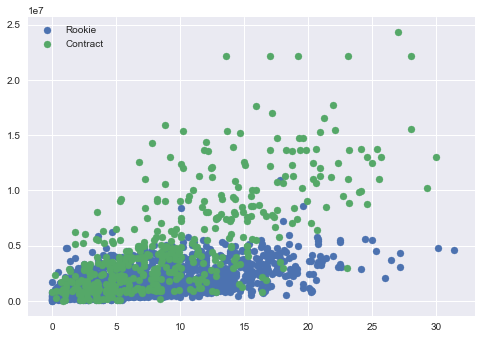

In [101]:
#sns.boxplot(data=df_rookie_total['AST'])

rookie = plt.scatter(x=df_rookie_total['PTS'],y=df_rookie_total['Salary'])
contract = plt.scatter(x=df_contract_total['PTS'],y=df_contract_total['Salary'])
plt.legend((rookie,contract),('Rookie','Contract'))

plt.show()

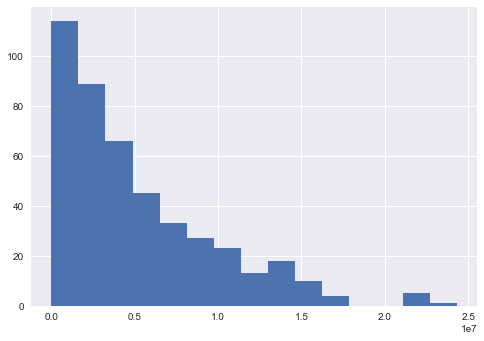

In [103]:
plt.hist(df_contract_total['Salary'],bins=15)
plt.show()

In [ ]:
df_rookie_total